In [128]:
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from textstat.textstat import textstat

%matplotlib inline

### Loading data for selection

In [277]:
considered_samples = 300000
values_per_label = 12500

In [284]:
columns_full = ['title', 'keywords', 'readingTime', 'text']
columns = ['title', 'keywords', 'readingTime', 'text', 'num_images', 'num_tags', 'count_tag_fol', 
           'count_tag_posts', 'weekday', 'seconds', 'count_words', 'FK_grade']

def get_short_info(obj):
    return [obj['likes']]

def get_full_info(obj):
    res = []
    for col in columns_full:
        if col == 'keywords':
            res.append(' '.join(obj[col]))
        else:
            res.append(obj[col])
            
    res.append(len(obj['images']))
    res.append(len(obj['tags']))
    res.append(sum(list(map(lambda x: x['followerCount'], obj['tags']))))
    res.append(sum(list(map(lambda x: x['postCount'], obj['tags']))))
    
    date = datetime.datetime.fromtimestamp(float(obj['date']['$numberLong'])/1000.)
    res.append(date.weekday())
    res.append(date.hour*60*60 + date.minute*60 + date.second)
    res.append(len(obj['text'].split(' ')))
    try:
        res.append(textstat.flesch_kincaid_grade(obj['text']))
    except Exception as e:
        res.append(0)
        
    return res

data = []
ind = []

for i, l in enumerate(open('data/medium.json')):
    obj = json.loads(l)
    ind.append(obj['id'])
    data.append(get_short_info(obj))
    if len(data) > considered_samples:
        break

In [285]:
df = pd.DataFrame(data, index=ind, columns=['likes'])

df['group'] = 0
borders = [1e-20, 2, 4, np.inf]

print(len(df[df.likes == 0]))

bins = [df[df.likes == 0].sample(values_per_label, replace=True)]
for i in range(1, len(borders)):
    ins = np.logical_and(np.log1p(df.likes) < borders[i], np.log1p(df.likes) >= borders[i-1])
    print(len(df[ins]))
    df.loc[ins, 'group'] = i
    bins.append(df[ins].sample(values_per_label, replace=True))
    
df = pd.concat(bins)

125828
128650
34228
11295


In [286]:
ind = df.index
new_info = {}

count = 0
for i, l in enumerate(open('data/medium.json')):
    obj = json.loads(l)
    if i > considered_samples:
        break
    if i % 1000 == 0:
        print('.', end='')
    if obj['id'] in ind and obj['id'] not in new_info:
        new_info[obj['id']] = get_full_info(obj)

..Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
.Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
.Error(ASyPW): Number of words are zero, cannot divide
.Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
.Error(ASyPW): Number of words are zero, cannot divide
..Error(ASyPW): Number of words are zero, cannot divide
..Error(ASyPW): Number of words are zero, cannot divide
.Error(ASyPW): Number of words are zero, cannot divide
..Error(ASyPW): Number of words are zero, cannot divide
.Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
....Error(ASyP

In [287]:
new_df = pd.DataFrame.from_dict(new_info, orient='index')
new_df.columns = columns
df = pd.merge(df, new_df, 'inner', left_index=True, right_index=True)

df.head()

,likes,group,title,keywords,readingTime,text,num_images,num_tags,count_tag_fol,count_tag_posts,weekday,seconds,count_words,FK_grade
100527abd288,9,2,"Backwoods, Pennsylvania",Horror Hiking Abandoned Short Story Investigation,9.355660,"It was 5:27 on Monday night, October 17th, and...",7,5,286227,42579,3,76335,2154,7.5
1005e11d0736,0,0,Leitura aconselhada,Livros Criancas Pais E Filhos Bébéu Bebes,0.960692,Adoro livros para crianças e dou muita importâ...,2,5,387,1514,3,61524,147,9.4
10064c2cabe2,36,2,The Day I Stayed Seated,Music Piano Divorce Memoir High School,3.196226,I learned to stand for myself the day I stayed...,1,5,179046,22280,0,78779,775,5.1
1006b69b5b75,0,0,3/100,Fiction Short Story Life,1.418868,Louise sat in the bed and took a final look ar...,1,3,1273818,155241,3,2153,320,5.4
10075f2fd906,0,0,The 7 Types of People You Meet at the Gym,Fitness Weightlifting Comedy Writing Lol Gym,2.555660,Appearance: Whether their headphones are in or...,7,5,4062,18244,2,11139,369,7.0


### Prepare text features

In [288]:
from sklearn.feature_extraction.text import HashingVectorizer
all_texts = np.hstack([df.text.values,df.title.values,df.keywords])

hv = HashingVectorizer(ngram_range=(1,3), n_features=2**15)
text_features = hv.fit_transform(all_texts)

In [289]:
text_tokens = text_features[:values_per_label*4]
title_tokens = text_features[values_per_label*4:8*values_per_label]
keywords_tokens = text_features[8*values_per_label:]

### Train/test splitting

In [290]:
indexes = df.index.values
target = df.group.values.astype('int8')

num_cols = ['readingTime', 'num_images', 'num_tags', 'count_tag_fol', 'count_tag_posts', 'weekday', 'seconds', 'count_words']
df_non_text = df[num_cols].values.astype('float32')

In [291]:
from sklearn.model_selection import train_test_split
data_tuple = train_test_split(indexes,title_tokens,text_tokens,keywords_tokens,df_non_text,target)

ind_tr,ind_ts,title_tr,title_ts,text_tr,text_ts,keyw_tr,keyw_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple

### Save (load) progress

In [292]:
import pickle

# Save

# with open("preprocessed_data_dense.pcl",'wb') as fout:
#     pickle.dump(data_tuple,fout)

# Load

with open("preprocessed_data_dense.pcl",'rb') as fin:
    data_tuple = pickle.load(fin)
ind_tr,ind_ts,title_tr,title_ts,text_tr,text_ts,keyw_tr,keyw_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple


In [206]:
###############################################
## If you want to append some extra features ##
##      there is the best place for them     ##
###############################################

### NN Stuff

In [304]:
import lasagne
from theano import tensor as T
import theano

title_token_ids = T.matrix("title_token_ids",dtype='float64')
text_token_ids = T.matrix("text_token_ids",dtype='float64')
keyw_token_ids = T.matrix("keyw_token_ids",dtype='float64')
non_text = T.matrix("non_text",dtype='float64')
target_y = T.ivector("group")

In [305]:
###########
## Input ##
###########

title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
text_inp = lasagne.layers.InputLayer((None,text_tr.shape[1]),input_var=text_token_ids)
keyw_inp = lasagne.layers.InputLayer((None,keyw_tr.shape[1]),input_var=keyw_token_ids)
cat_inp = lasagne.layers.InputLayer((None,df_non_text.shape[1]), input_var=non_text)

####################
## Parallel Convs ##
####################

text_nn = lasagne.layers.DenseLayer(text_inp, 512)
text_nn = lasagne.layers.BatchNormLayer(text_nn)

title_nn = lasagne.layers.DenseLayer(title_inp, 512)
title_nn = lasagne.layers.BatchNormLayer(title_nn)

keyw_nn = lasagne.layers.DenseLayer(keyw_inp, 512)
keyw_nn = lasagne.layers.BatchNormLayer(keyw_nn)

cat_nn = lasagne.layers.DenseLayer(cat_inp, 512)
cat_nn = lasagne.layers.BatchNormLayer(cat_nn)

########################
## Merging and Output ##
########################

nn = lasagne.layers.concat([text_nn, title_nn, keyw_nn, cat_nn])                               
nn = lasagne.layers.DenseLayer(nn,128, nonlinearity=lasagne.nonlinearities.sigmoid)
nn = lasagne.layers.DropoutLayer(nn,p=0.05)
nn = lasagne.layers.DenseLayer(nn,4,nonlinearity=lasagne.nonlinearities.softmax)

In [306]:
weights = lasagne.layers.get_all_params(nn,trainable=True)
prediction = lasagne.layers.get_output(nn)

loss = lasagne.objectives.multiclass_hinge_loss(prediction, target_y).mean()
updates = lasagne.updates.adadelta(loss, weights)

det_prediction = lasagne.layers.get_output(nn,deterministic=True)
det_loss = lasagne.objectives.multiclass_hinge_loss(det_prediction, target_y).mean()

In [307]:
train_fun = theano.function([text_token_ids,title_token_ids,keyw_token_ids,non_text,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([text_token_ids,title_token_ids,keyw_token_ids,non_text,target_y],[det_loss,det_prediction])

### Minibatch training

In [ ]:
def iterate_minibatches(*arrays,**kwargs):
    
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[-1]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[-1]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from scipy.sparse import csr_matrix

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100

def pr_auc(y_true, y_pred):
    pr, rec, _ = precision_recall_curve(y_true, y_pred)
    return '%.3f' % auc(rec, pr)

for i in range(n_epochs):
    
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_text,b_title,b_keyw, b_cat, b_y) in enumerate(
        iterate_minibatches(text_tr,title_tr,keyw_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
        loss,value = train_fun(b_text.toarray(),b_title.toarray(),b_keyw.toarray(),b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(value)
        print('.',end='')

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("\nTrain:")
    print('\tAverage loss:', b_loss/b_c)
    print('\tAUC:', ['%.3f' % roc_auc_score(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])
    print('\tPR AUC:',[pr_auc(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])
    
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_text,b_title,b_keyw,b_cat, b_y) in enumerate(
        iterate_minibatches(text_ts,title_ts,keyw_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,value = eval_fun(b_text.toarray(),b_title.toarray(),b_keyw.toarray(),b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(value)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("Val:")
    print('\tAverage loss:', b_loss/b_c)
    print('\tAUC:', ['%.3f' % roc_auc_score(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])
    print('\tPR AUC:',[pr_auc(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])

...................................................

In [299]:
from sklearn.metrics import confusion_matrix, roc_curve

epoch_y_true = []
epoch_y_pred = []
b_c = b_loss = 0
for j, (b_text,b_title,b_keyw,b_cat, b_y) in enumerate(
    iterate_minibatches(text_ts,title_ts,keyw_ts,nontext_ts,target_ts,batchsize=batch_size//2,shuffle=True)):
    loss,value = eval_fun(b_text.toarray(),b_title.toarray(),b_keyw.toarray(),b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(value)
    print(end='.')


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

print('\nConfusion matrix')
cm = confusion_matrix(epoch_y_true, np.argmax(epoch_y_pred, axis=1))
print(cm/cm.sum(axis=1).reshape(-1,1))
print('AUC:', ['%.3f' % roc_auc_score(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])
print('PR AUC:',[pr_auc(epoch_y_true == i, epoch_y_pred[:,i]) for i in range(4)])

..........................................................................................................................................................................................................................................................
Confusion matrix
[[  0.00000000e+00   9.99031321e-01   0.00000000e+00   9.68679367e-04]
 [  0.00000000e+00   9.99687988e-01   3.12012480e-04   0.00000000e+00]
 [  0.00000000e+00   9.98676373e-01   6.61813369e-04   6.61813369e-04]
 [  0.00000000e+00   9.94017632e-01   9.44584383e-04   5.03778338e-03]]
AUC: ['0.715', '0.461', '0.539', '0.737']
PR AUC: ['0.406', '0.231', '0.271', '0.398']


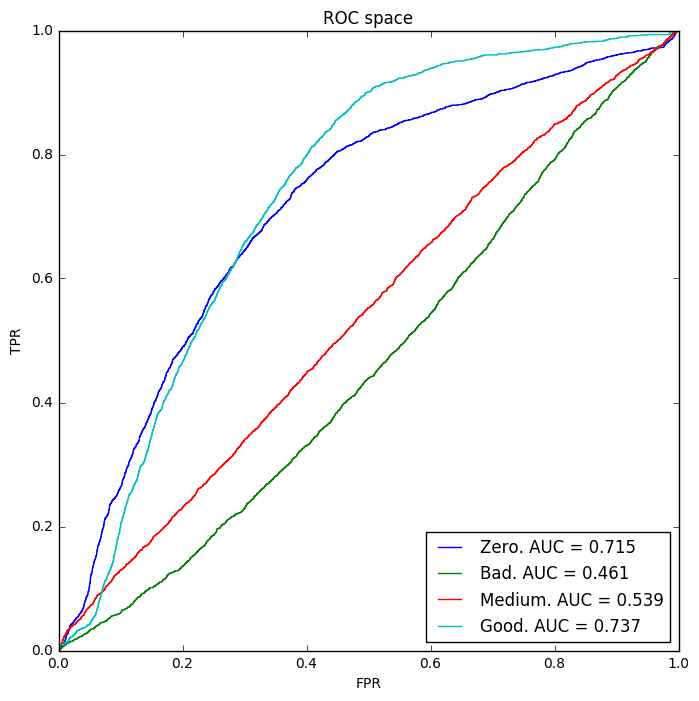

In [300]:
classes = ['Zero', 'Bad', 'Medium', 'Good']
plt.figure(figsize=(8,8))
for i in range(4):
    fpr, tpr, _ = roc_curve(epoch_y_true == i, epoch_y_pred[:,i])
    plt.plot(fpr, tpr, label = classes[i] + '. AUC = %.3f' % roc_auc_score(epoch_y_true == i, epoch_y_pred[:,i]))
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC space');

In [301]:
np.bincount(epoch_y_true)

array([3097, 3205, 3022, 3176])

In [302]:
np.bincount(np.argmax(epoch_y_pred, axis=1))

array([    0, 12473,     6,    21])